<a href="https://colab.research.google.com/github/PrithiviRajMK/ScalerProjects/blob/main/Ninja_Cart_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ninja Cart Computer vision


Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

Import Packages

In [2]:
# Import required packages
# Import the required libraries

import pandas as pd
import seaborn as sns

import warnings

from datetime import datetime
warnings.filterwarnings('ignore')
from keras.models import Sequential

import tensorflow as tf

import tensorflow_datasets as tfds


from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image



Import & Load data

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Ninja Cart/ninjacart_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/ninja')

  zip.close()
  print('Done')

Done


In [5]:

drive.flush_and_unmount()

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import keras

In [7]:
image_size = (224, 224)
batch_size = 32

train_dataset = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/train',
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'training',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

val_dataset = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/train',
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.


In [8]:

train_dir = '/content/ninja/ninjacart_data/train'
class_names = os.listdir(train_dir)

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")

indian market: 599 images
tomato: 789 images
onion: 849 images
potato: 898 images


In [10]:
test_ds = image_dataset_from_directory(
    '/content/ninja/ninjacart_data/test',
    labels = 'inferred',
    label_mode = 'int',
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 351 files belonging to 4 classes.


In [11]:
test_dir = '/content/ninja/ninjacart_data/test'
class_names = os.listdir(test_dir)

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")


indian market: 81 images
tomato: 106 images
onion: 83 images
potato: 81 images


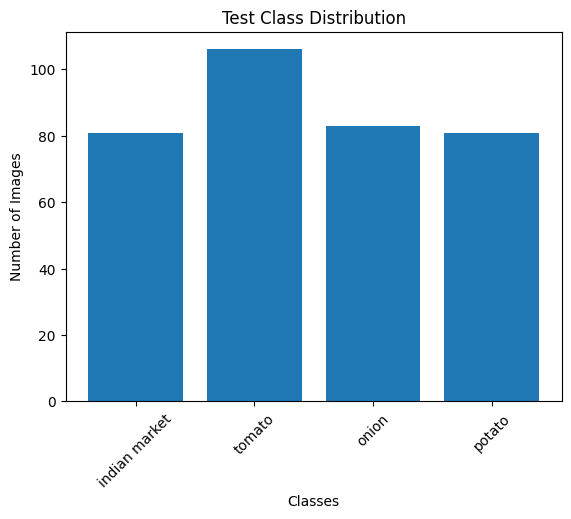

In [12]:
test_class_counts = [len(os.listdir(os.path.join(test_dir, class_name))) for class_name in class_names]

plt.bar(class_names, test_class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Test Class Distribution')
plt.xticks(rotation=45)
plt.show()

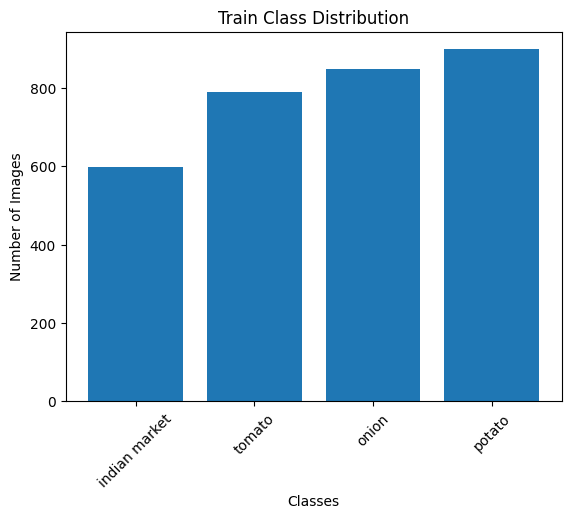

In [9]:
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]

plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Train Class Distribution')
plt.xticks(rotation=45)
plt.show()

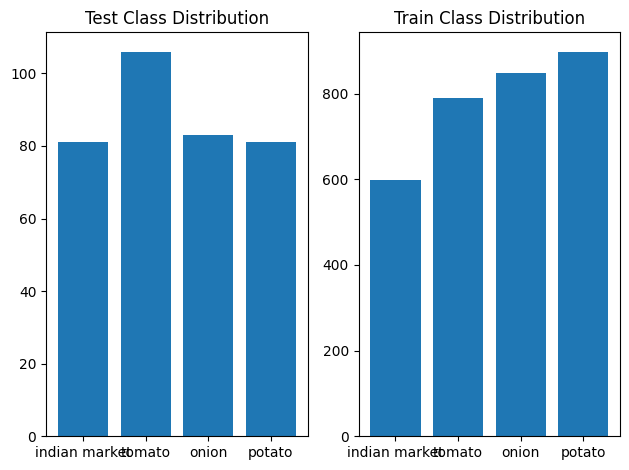

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].bar(class_names, test_class_counts)
#axes[0].xlabel('Classes')
#axes[0].ylabel('Number of Images')
#axes[1].set_title('Subplot 2')
axes[0].set_title('Test Class Distribution')
#axes[0].xticks(rotation=45)

# Plot on the second subplot (right column)
axes[1].bar(class_names, class_counts)
#axes[1].xlabel('Classes')
#axes[1].ylabel('Number of Images')
axes[1].set_title('Train Class Distribution')

#axes[1].title('Train Class Distribution')
#axes[1].xticks(rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with subplots
plt.show()

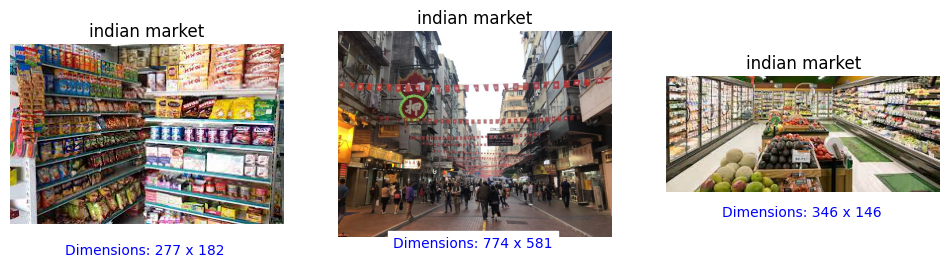

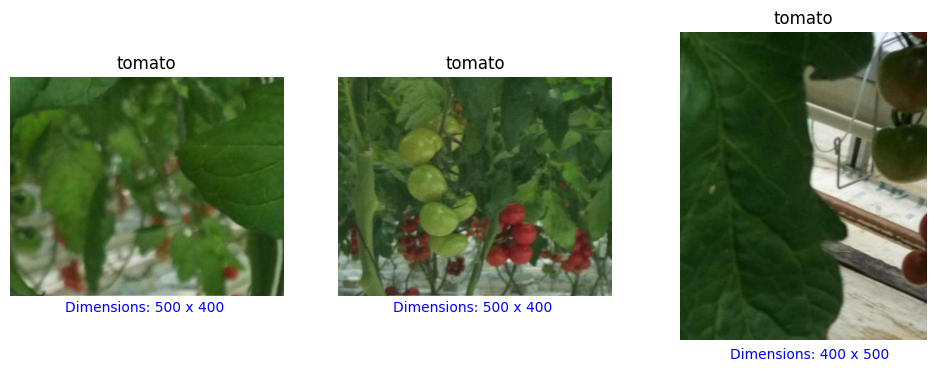

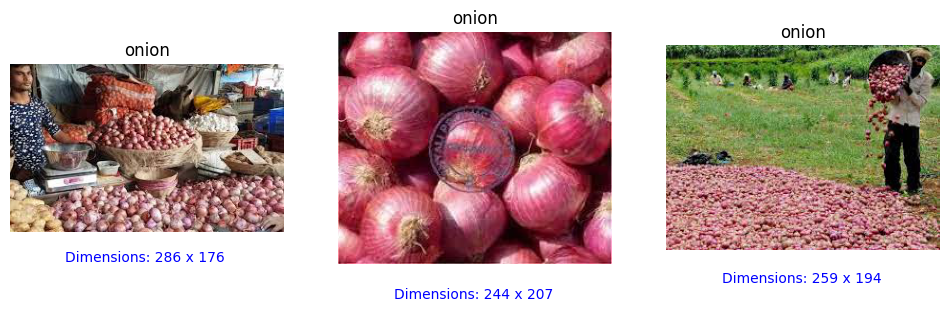

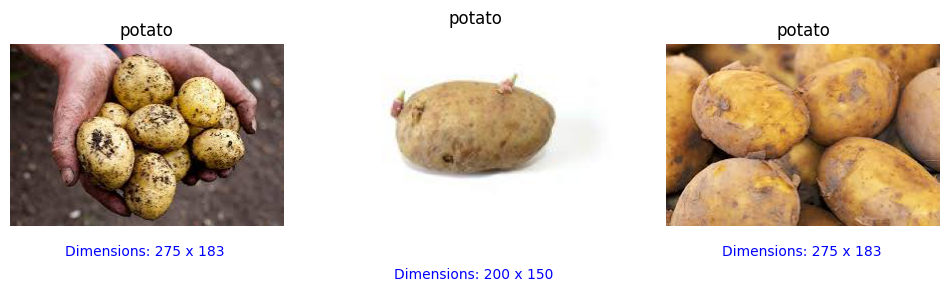

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the number of images to display per class
num_images_to_display = 3

# Loop over each class and display sample images
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_to_display]

    # Create a subplot for each image
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))

    # Loop over image files and display them
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_name)

        # Get image dimensions and display them as text
        width, height = image.size
        axes[i].text(width/5, height+30, f"Dimensions: {width} x {height}", color='blue', backgroundcolor='white')

    plt.show()

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                validation_split=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255., validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory('/content/ninja/ninjacart_data/train',
                                                    subset='training',
                                                    batch_size = 32,
                                                    class_mode = 'sparse',
                                                    target_size=(224, 224))

test_generator = test_datagen.flow_from_directory('/content/ninja/ninjacart_data/test',
                                                  batch_size=32,
                                                  class_mode = 'sparse',
                                                  target_size = (224, 224))

val_generator = val_datagen.flow_from_directory('/content/ninja/ninjacart_data/train',
                                                    subset='validation',
                                                    batch_size = 32,
                                                    class_mode = 'sparse',
                                                    target_size=(224, 224))

Found 2511 images belonging to 4 classes.
Found 351 images belonging to 4 classes.
Found 624 images belonging to 4 classes.


In [ ]:
# Get a batch of data from the train generator
x_train, y_train = next(train_generator)

# Verify the shape of the input data and labels
print("Train data shape:", x_train.shape)
print("Train labels shape:", y_train.shape)

# Get a batch of data from the test generator
x_test, y_test = next(test_generator)

# Verify the shape of the input data and labels
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Train data shape: (32, 224, 224, 3)
Train labels shape: (32,)
Test data shape: (32, 224, 224, 3)
Test labels shape: (32,)


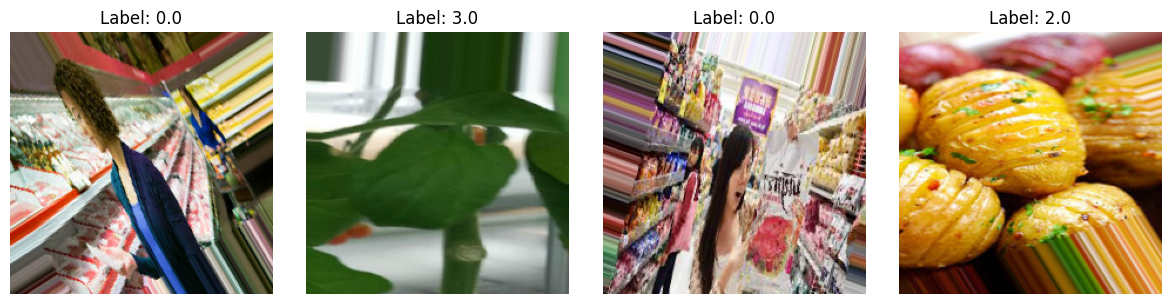

In [ ]:
import matplotlib.pyplot as plt

# Plot a few images with labels from the train generator
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(x_train[i])
    axes[i].set_title("Label: {}".format(y_train[i]))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
NUM_CLASSES = 5

model =tf.keras.Sequential([
                               tf.keras.layers.Flatten(input_shape=(224,224,3)),
                               tf.keras.layers.Dense(256,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(512,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(1024,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(NUM_CLASSES, kernel_initializer='zeros',activation=tf.keras.activations.softmax),

])

In [ ]:
SCHEDULE_BOUNDARIES = [20, 40, 60]
BATCH_SIZE = 128
lr = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:

hist = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    verbose = 2
)

Epoch 1/10
79/79 - 50s - loss: 1.4049 - accuracy: 0.2616 - val_loss: 1.4173 - val_accuracy: 0.2308 - 50s/epoch - 630ms/step
Epoch 2/10
79/79 - 41s - loss: 1.3782 - accuracy: 0.2863 - val_loss: 1.4169 - val_accuracy: 0.2308 - 41s/epoch - 515ms/step
Epoch 3/10
79/79 - 40s - loss: 1.3781 - accuracy: 0.2859 - val_loss: 1.4165 - val_accuracy: 0.2308 - 40s/epoch - 511ms/step
Epoch 4/10
79/79 - 41s - loss: 1.3758 - accuracy: 0.2855 - val_loss: 1.4161 - val_accuracy: 0.2308 - 41s/epoch - 514ms/step
Epoch 5/10
79/79 - 41s - loss: 1.3760 - accuracy: 0.2963 - val_loss: 1.4156 - val_accuracy: 0.2308 - 41s/epoch - 522ms/step
Epoch 6/10
79/79 - 41s - loss: 1.3793 - accuracy: 0.2851 - val_loss: 1.4152 - val_accuracy: 0.2308 - 41s/epoch - 523ms/step
Epoch 7/10
79/79 - 39s - loss: 1.3794 - accuracy: 0.2812 - val_loss: 1.4148 - val_accuracy: 0.2308 - 39s/epoch - 498ms/step
Epoch 8/10
79/79 - 39s - loss: 1.3774 - accuracy: 0.2903 - val_loss: 1.4144 - val_accuracy: 0.2308 - 39s/epoch - 497ms/step
Epoch 9/

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\n Test Accuracy: ", round(test_acc,2)*100, "%")

11/11 - 3s - loss: 1.4136 - accuracy: 0.2308 - 3s/epoch - 258ms/step

 Test Accuracy:  23.0 %


In [ ]:

preds = model.predict(test_generator)
predicted_labels = np.argmax(preds, axis=1)

11/11 [==============================] - 2s 169ms/step


In [ ]:
# class_names = []
final_predictions = [class_name[i] for i in predicted_labels]

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Constants
NUM_CLASSES = 4
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 10

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model's layers
vgg_model.trainable = False

# Create the model
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

vgg_model = model
# Print model summary
vgg_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
___________________________________

In [ ]:
# Compile the model
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/test',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create TensorBoard callback for VGG model
vgg_tensorboard_callback = TensorBoard(log_dir='/content/logs/vgg')



Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


In [ ]:
# Train the Model
vgg_history = vgg_model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = EPOCHS,
    verbose = 2,
    callbacks = [vgg_tensorboard_callback]
)


Epoch 1/10
79/79 - 1928s - loss: 1.0393 - accuracy: 0.7081 - val_loss: 0.3346 - val_accuracy: 0.8814 - 1928s/epoch - 24s/step
Epoch 2/10


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import TensorBoard


# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model's layers
resnet_model.trainable = False

# Create the model
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

resnet_model = model
# Print model summary
resnet_model.summary()

In [ ]:
# Compile the Resnet model
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/train',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/ninja/ninjacart_data/test',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create TensorBoard callback for ResNet model
resnet_tensorboard_callback = TensorBoard(log_dir='/content/logs/resnet')


In [ ]:

# Train the Resnet model
resnet_history = resnet_model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples,
    epochs=EPOCHS,
    callbacks=[resnet_tensorboard_callback]
)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Make predictions with the VGG model
vgg_predictions = vgg_model.predict(test_generator)
vgg_predicted_labels = np.argmax(vgg_predictions, axis=1)
vgg_true_labels = test_generator.classes

# Make predictions with the ResNet model
resnet_predictions = resnet_model.predict(test_generator)
resnet_predicted_labels = np.argmax(resnet_predictions, axis=1)
resnet_true_labels = test_generator.classes

# Compute confusion matrices
vgg_cm = confusion_matrix(vgg_true_labels, vgg_predicted_labels)
resnet_cm = confusion_matrix(resnet_true_labels, resnet_predicted_labels)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - VGG Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(1, 2, 2)
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - ResNet Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='VGG Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG Validation Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='VGG Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG Validation Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Training Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test the models on the test set
test_loss_vgg, test_accuracy_vgg = vgg_model.evaluate(test_generator)
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_generator)

print("VGG Model - Test Accuracy:", round(test_accuracy_vgg,2)*100)
print("ResNet Model - Test Accuracy:", round(test_accuracy_resnet,2)*100)
print()

# Generate predictions for random image samples
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize the image
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Random image samples
image_paths = [
    '/content/ninja/ninjacart_data/test/indian market/indianmarket20.jpeg',
    '/content/ninja/ninjacart_data/test/onion/28W1CL9LAL32.jpg',
    '/content/ninja/ninjacart_data/test/potato/potato1105.jpeg',
    '/content/ninja/ninjacart_data/test/tomato/tomato150.png'
]

# Predict and display the results
for image_path in image_paths:
    predicted_class_vgg = predict_image(vgg_model, image_path)
    predicted_class_resnet = predict_image(resnet_model, image_path)

    print("Image:", image_path)
    print("VGG Model Prediction:", predicted_class_vgg)
    print("ResNet Model Prediction:", predicted_class_resnet)
    print()

